In [19]:
import os
import sys
import numpy as np
import itertools
import matplotlib.pyplot as plt
from math import pi
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import inspect
import orbithunter.ks as ks
import h5py
import time
from orbithunter.shadowing import factor_prime_mask, first_nprimes
import orbithunter.persistent_homology as ohgudhi
# from orbithunter.persistent_homology import gudhi_distance_from_persistence
from orbithunter.persistent_homology import gudhi_distance_from_persistence, orbit_persistence

# Covering space-time with fundamental orbits.

This notebook produces statistics on the shadowing and covering of space-time by fundamental orbits.
The steps are as follows

    1. Produce a set of fundamental orbits whose combinations are believed to span all possible patterns
    2. Produce a (large) set of windows from trajectories
    3. Calculate the shadowing/covering metric between each window and each fundamental orbit (and group orbits)
    4. Using these distributions, determine a good absolute threshold for the computation of the various coverings.
    5. With each fundamental orbit and its group orbit (if statistics are the same, which they should be, approximately)
       compute the fraction of the large spacetime simulations that each group orbit covers. This can be done
       via either 
    
    
With results from ```continuation.ipynb``` and ```shadowing.ipynb``` we can begin the actual covering portion.

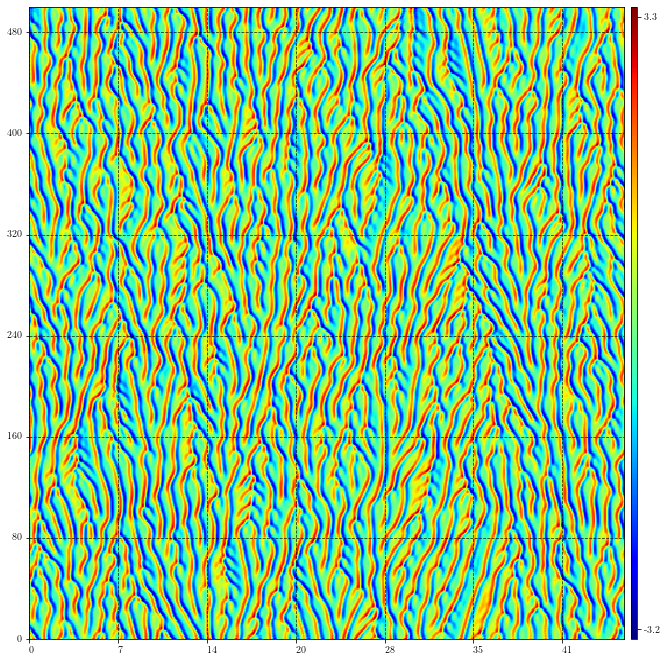

In [2]:
base = read_h5('../../notebooks/large_trajectories.h5', '/1')
base.plot()

In [3]:
read_h5('small_cover.h5')

[RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [15.451, 13.029, -3.356]}),
 RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [24.957, 12.919, -3.236]}),
 RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [6.93, 13.202, -3.242]}),
 RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [9.03, 13.2, -4.224]}),
 RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [15.97, 17.57, -5.661]}),
 RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [19.07, 17.568, -5.754]}),
 EquilibriumOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [0.0, 7.162, 0.0]}),
 EquilibriumOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [0.0, 7.762, 0.0]}),
 AntisymmetricOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [15.24, 17.399, 0.0]}),
 AntisymmetricOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [21.199, 17.859, 0.0]})]

In [4]:
covering = [x.transform(to='field') for x in read_h5('small_cover.h5')]
base = read_h5('../../notebooks/large_trajectories.h5', '/1')


# square discretiz|ations for persistent homology
covering_processed  = ([rpo.to_fundamental_domain() for rpo in covering[:6]] 
                        + [anti for anti in  covering[-2:]])

I'm explicitly writing the critical values here, however, they are included as metadata in the corresponding covering .h5 files. The "strict" values are the values corresponding to the 0.01%, that is, only expect to capture NM/10000 points. 

# Single cover, no group orbits

As a preliminary trial, run the covering routine with only the set of covering orbits, not accounting for their
symmetry group orbits. This will give an idea as to whether it will be possible to cover the space. For each fundamental
orbit in the cover, resize it so it has the same spacing as the base. Then, compute the amplitude difference at each
site. If the amplitude difference is smaller than the bottom 0.1% of all scores (as computed by the sampling performed
in ```shadowing.ipynb```) then it is marked as a shadowing region.

To distinguish between overlaps and different orbits in the cover, the ```mask_type='prime'``` keyword argument is provided.
What this does is assigns a prime number (simply in order) to each orbit in the provided cover. Then, instead of producing True (1) for each site testing positive for shadowing, the logarithm of the corresponding prime number is provided. This is
motivated by the prime, the logarithmic sum is used instead of the product of primes for overflow reasons. Therefore, each
site can be factored into a product of primes of multiplicity 1, hence, we can tell which orbits are shadowing which regions
of spacetime. 

The ideal cover is one wherein the covering orbits do not overlap considerably. Otherwise the proportion of the area covered
by each orbit isn't well defined. This may require discarding the points of overlap in the statistics calculations. 

Before any calculations, I am going to wager that the equilibrium orbits cannot be included simply due to the fact that all
orbits look like a configuration of streaks.

First, resize the covering according to the size of the base orbit they are being compared to. 

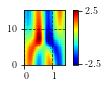

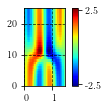

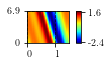

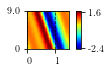

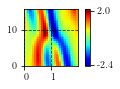

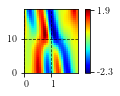

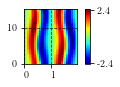

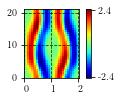

In [5]:
critical_values = []
fundamental_critical_values = []
strict_critical_values = []
strict_fundamental_critical_values = []
with h5py.File('small_cover.h5', 'r') as file:
    for x in file:
        strict_critical_values.append(file[x].attrs['critical_values'][0])
        critical_values.append(file[x].attrs['critical_values'][1])
        strict_fundamental_critical_values.append(file[x].attrs['fundamental_domain_critical_values'][0])
        fundamental_critical_values.append(file[x].attrs['fundamental_domain_critical_values'][1])

critical_values = fundamental_critical_values[:6] + critical_values[-2:]

for x in covering_processed:
    x.plot(padding=False)

In [6]:
# dt, dx = base.t/base.n, base.x/base.m
# for window in covering:
#     newdisc = int(2*((window.t/dt)//2)), int(2*((window.x/dx)//2))
#     covering_processed.append(window.resize(newdisc).transform(to='field'))
# covering_processed = np.array(covering_processed)[[0, 1, 2, 3, 4, 5, 8, 9]]

# strict_critical_values = np.array(strict_critical_values)[[0, 1, 2, 3, 4, 5, 8, 9]]
# critical_values = np.array(critical_values)[[0, 1, 2, 3, 4, 5, 8, 9]]
# fundamental_critical_values = np.array(fundamental_critical_values)[[0, 1, 2, 3, 4, 5, 8, 9]]
# strict_fundamental_critical_values = np.array(strict_fundamental_critical_values)[[0, 1, 2, 3, 4, 5, 8, 9]]



# Key criterion to determine


To do this, need to describe the three main modes of the cover function; determined by the returning mask type.

```mask_type=='prime'``` : Label every orbit in the provided collection with a prime number. For each orbit, find its individual cover, encode the detections by the (log)prime and add it to the total mask. In this manner overlaps are detected and can also be uniquely identified.

```mask_type=='count'``` : Compute the cover for each orbit in the collection, sum the total number of detections at each site.
This would be equivalent to determining the number of unique primes at each site and is really only included for convenience. Typically one would want to run 'prime' instead of count in every case, as it does the same routine and includes more information.

```mask_type=='family'``` **(Default)**: Orbits provided are treated as "equivalent" in the sense that the mask return is simply the union of all overlapping masks. Because of the nature of the overlapping this can dramatically reduce the number of metric computations, if the detection rate is high. If the detection rate is low, worst case scenario is bounded above by primes/count. Therefore, one should first run primes to identify approximate minimal sets which provide the best cover and then run this. Also, the prime number encoding that happens internally is *per orbit*; multiple runs with ```mask_type=='union'``` in conjunction with external encoding, encodes *per family* and is the prescribed manner for computing complete covers. 

As indicated by its name, ```mask_type=='family'``` is mainly designed for families, i.e. similar orbits of identical size expected to overlap. The reason being that 

Even in the context of the "family" method for calculating covering, if the number of group orbit members for each family member in the covering is large, the computations for a single family on a single domain can take a *very* long time; and this is when . Therefore, it behooves us to determine a subset of group orbit members which provide the most efficient covering, in terms of computational time per area. The idea here being that more group orbit members likely only contribute to overlaps. 

So, the two main steps are: 

    1. Determine efficient number of members per family, as determined by a area proportion per # members plot
    2. Determine efficient number of group members per family, as determined by a area proportion per # group members plot

In [9]:
t0=time.time_ns()
covering_mask_prime = cover(base, critical_values, covering_processed, mask_type='prime', score_type='pointwise')
t1=time.time_ns()

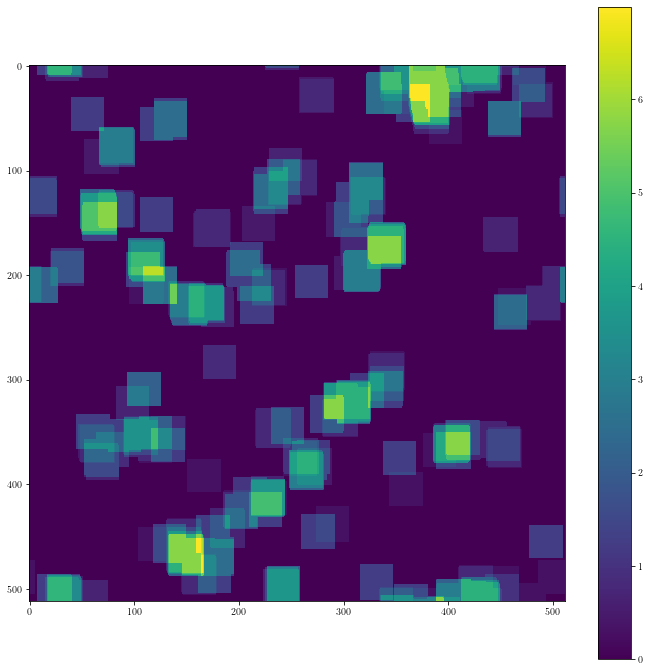

In [13]:
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(covering_mask_prime)
_ = plt.colorbar()

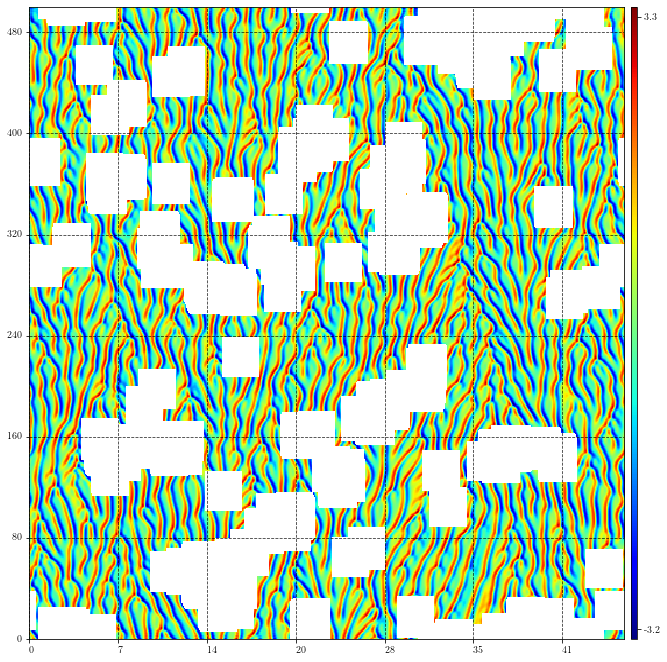

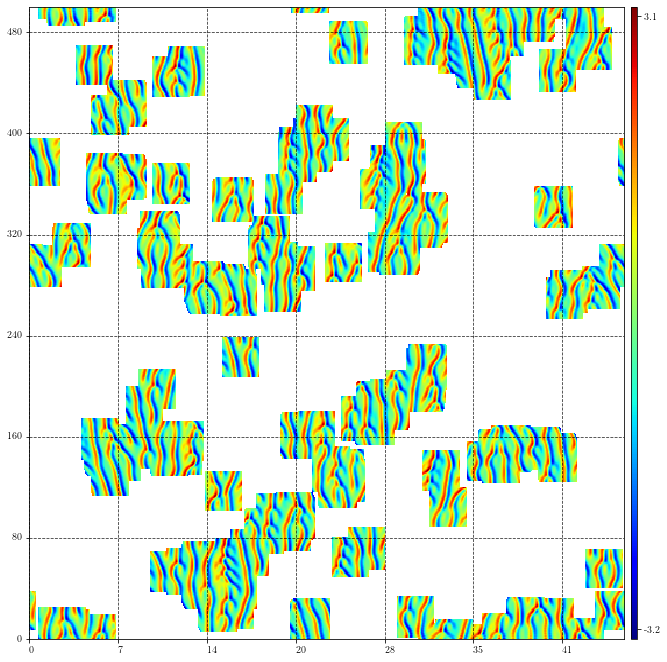

In [21]:
bool_mask = covering_mask_prime.copy()
bool_mask[bool_mask!=0]=1
base.__class__(state=np.ma.masked_array(base.state, mask=bool_mask, fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()
base.__class__(state=np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool)), fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()

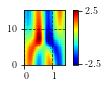

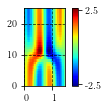

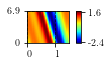

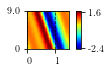

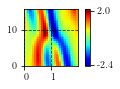

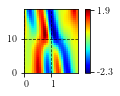

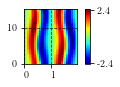

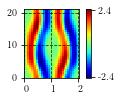

In [17]:
critical_persistence_values = []
fundamental_critical_persistence_values = []
strict_critical_persistence_values = []
strict_fundamental_critical_persistence_values = []
with h5py.File('small_cover.h5', 'r') as file:
    for x in file:
        strict_critical_persistence_values.append(file[x].attrs['critical_persistence_values'][0])
        critical_persistence_values.append(file[x].attrs['critical_persistence_values'][1])
        strict_fundamental_critical_persistence_values.append(file[x].attrs['fundamental_domain_critical_persistence_values'][0])
        fundamental_critical_persistence_values.append(file[x].attrs['fundamental_domain_critical_persistence_values'][1])

critical_persistence_values = fundamental_critical_persistence_values[:6] + critical_persistence_values[-2:]

for x in covering_processed:
    x.plot(padding=False)

In [20]:
t0=time.time_ns()
covering_mask_persistence_prime = cover(base, critical_persistence_values, covering_processed, mask_type='prime',
                          score_type='persistence',
                          scoring_function=gudhi_distance_from_persistence,
                          persistence_function=orbit_persistence,
                          gudhi_kwargs={'min_persistence': 0.25})
t1=time.time_ns()

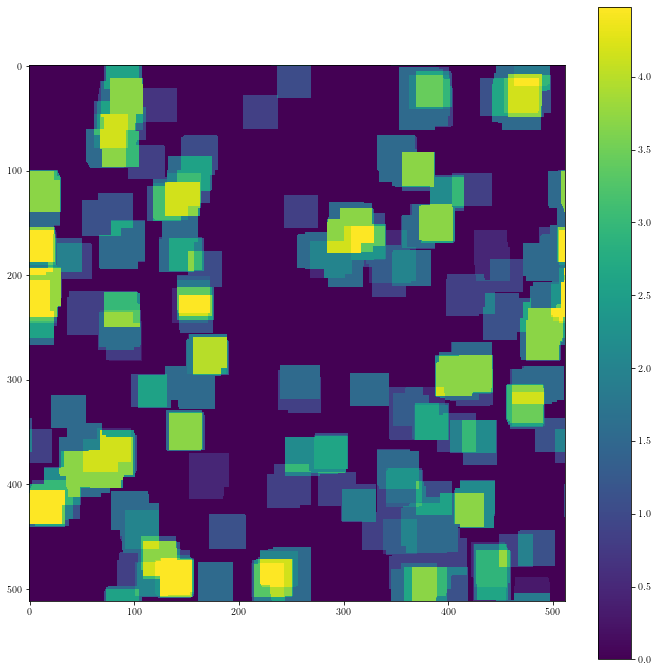

In [24]:
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(covering_mask_persistence_prime)
_ = plt.colorbar()

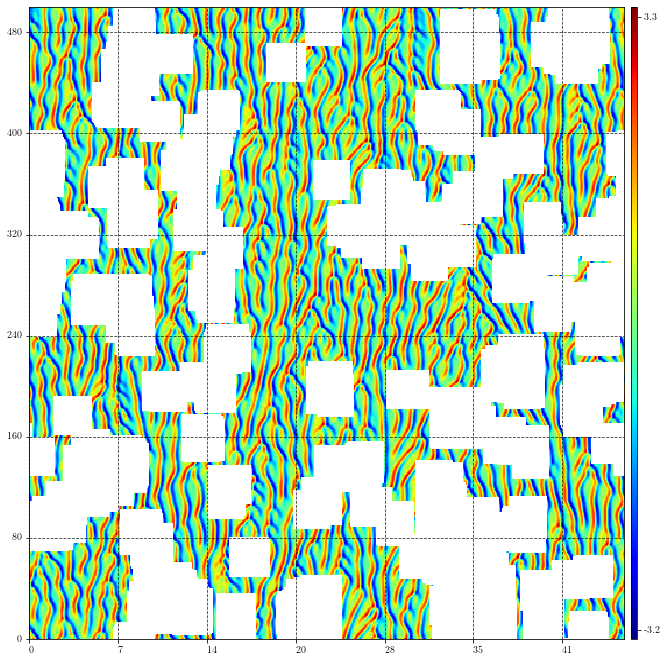

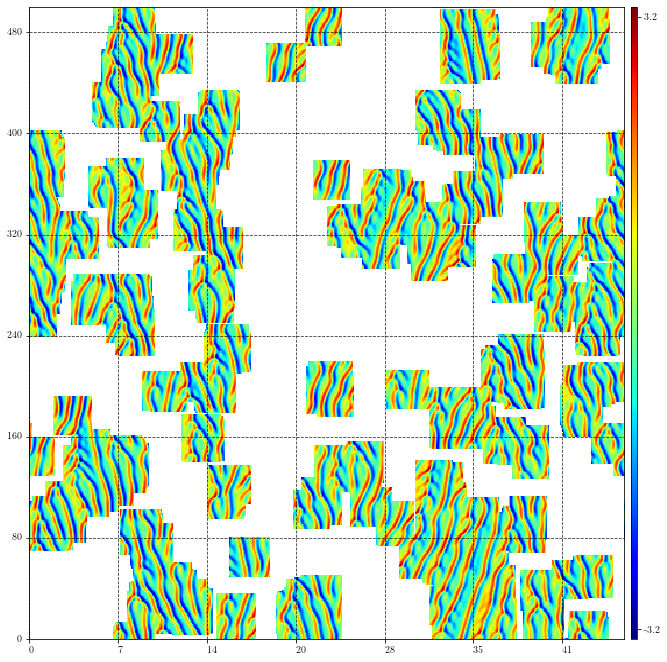

In [22]:
bool_mask = covering_mask_persistence_prime.copy()
bool_mask[bool_mask!=0]=1
base.__class__(state=np.ma.masked_array(base.state, mask=bool_mask, fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()
base.__class__(state=np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool)), fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()

The issue in this case is that 

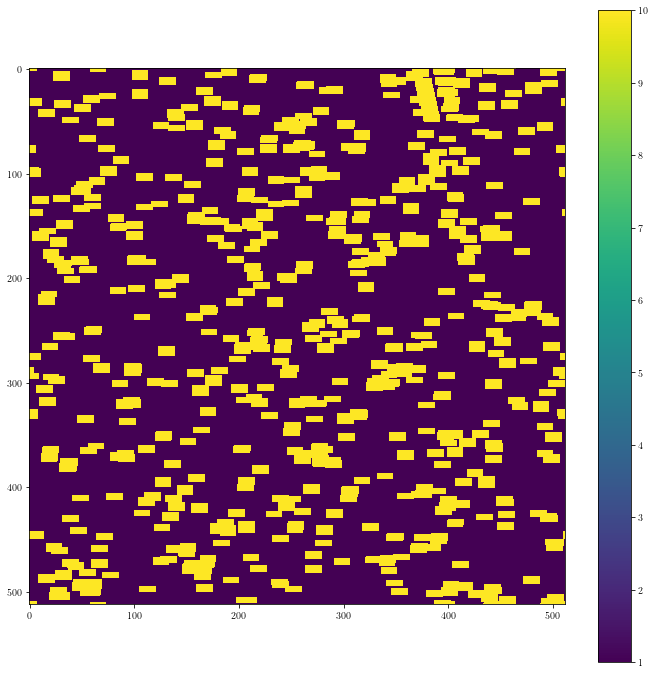

In [10]:
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(10**covering_mask)
_ = plt.colorbar()

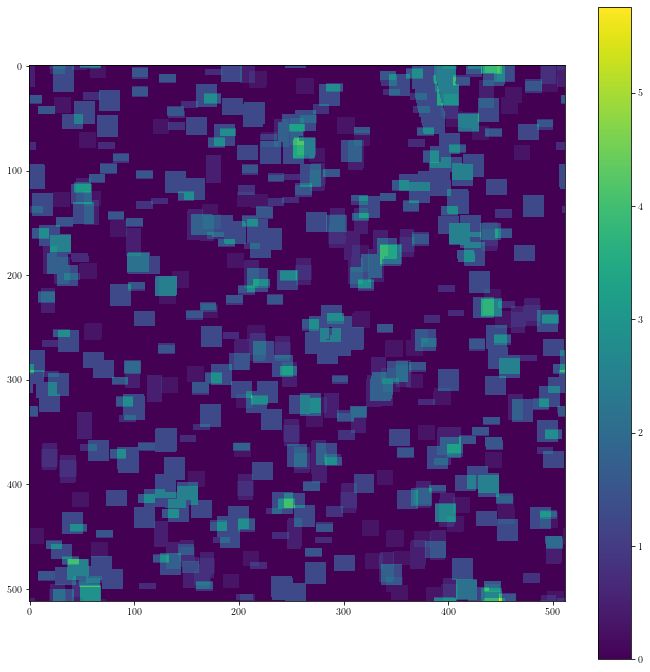

In [19]:
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(covering_mask_prime)
_ = plt.colorbar()

If you would like to look at how the mask factors into contributions by each orbit.

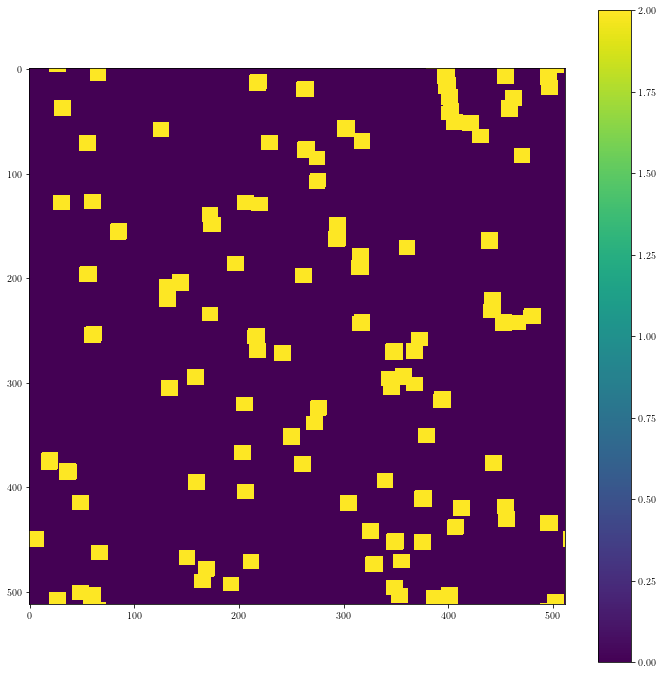

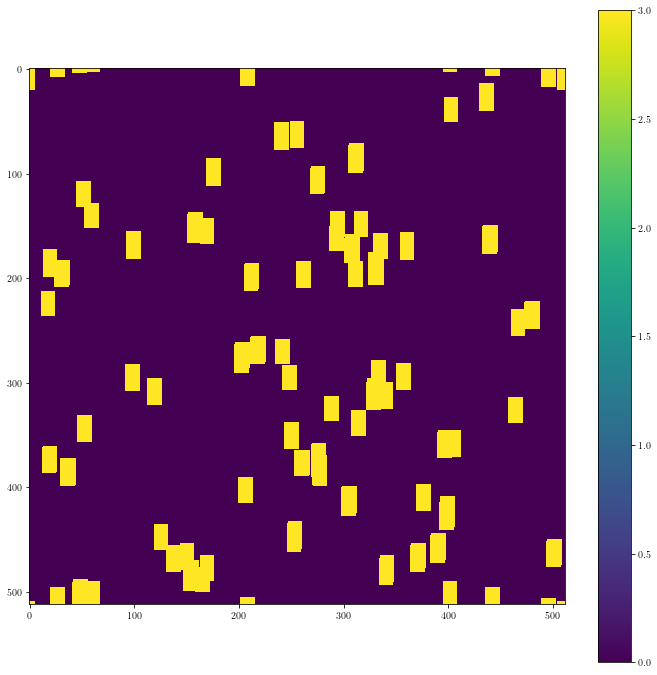

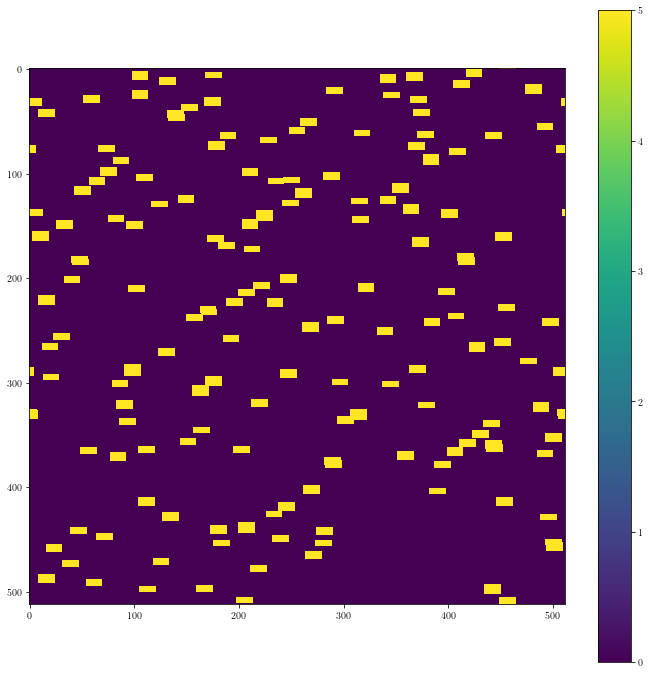

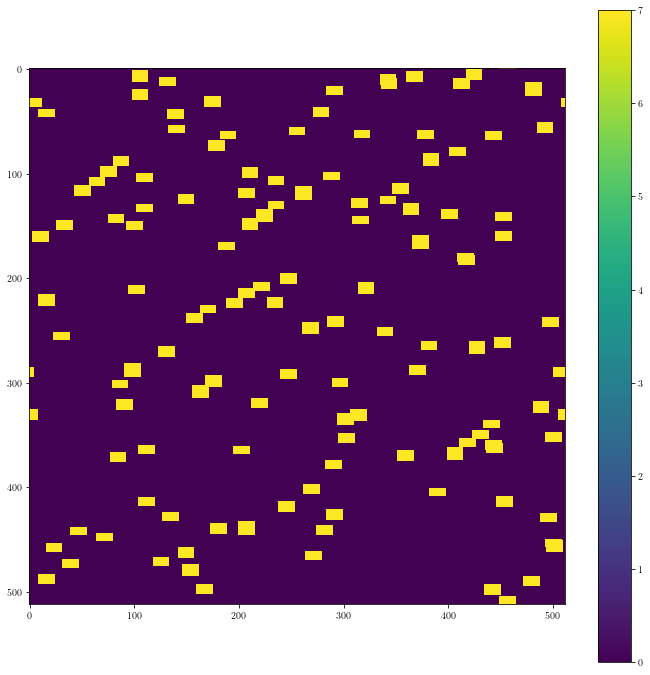

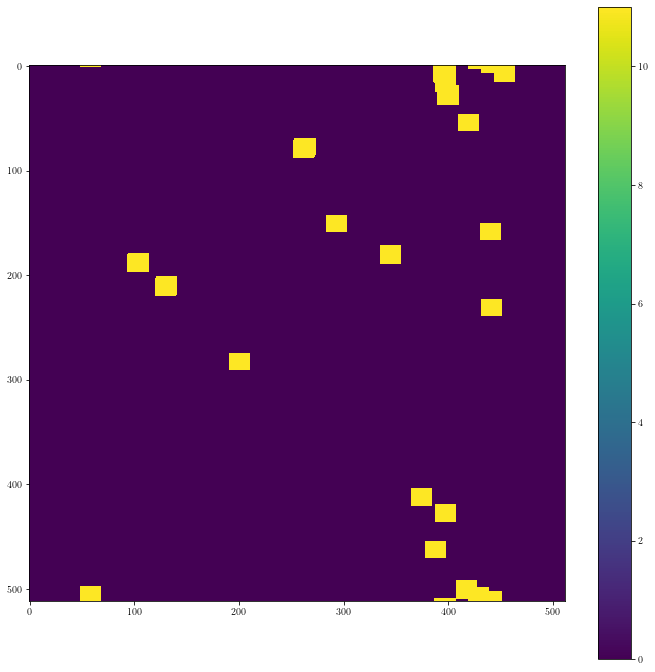

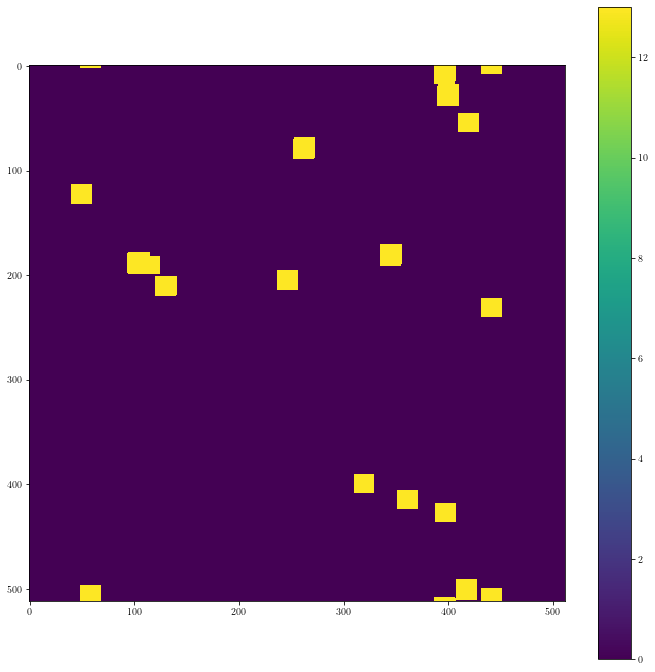

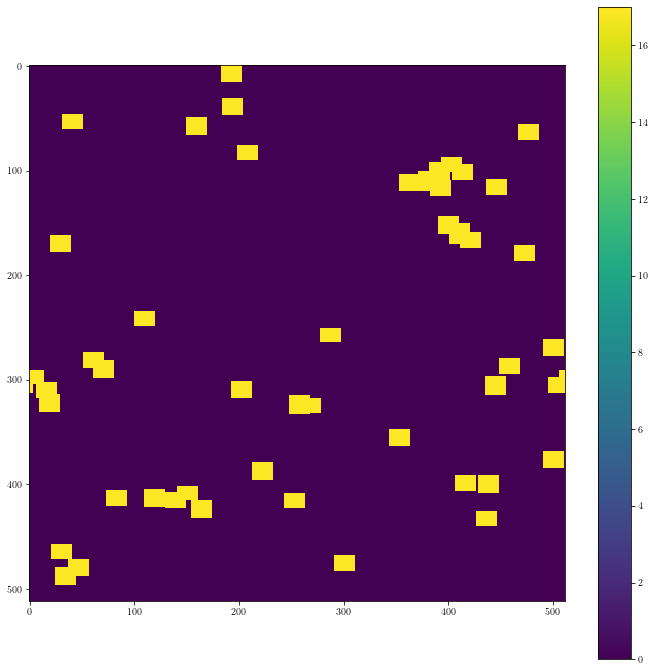

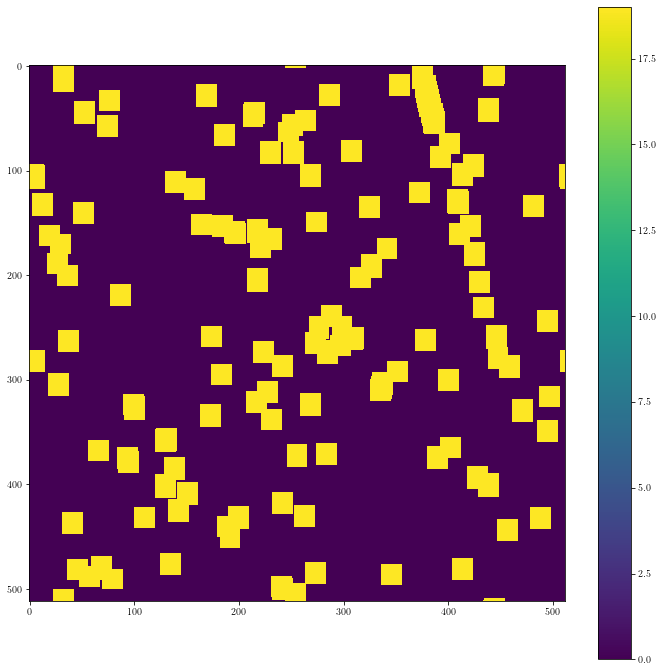

In [15]:
factors = factor_prime_mask(covering_mask_prime, first_nprimes(len(covering_processed)))
for f in factors:
    _ = plt.figure(figsize=(12,12))
    _ = plt.imshow(f)
    _ = plt.colorbar()

And when viewed in terms of the base orbit, both the interior and exterior produced by the mask.

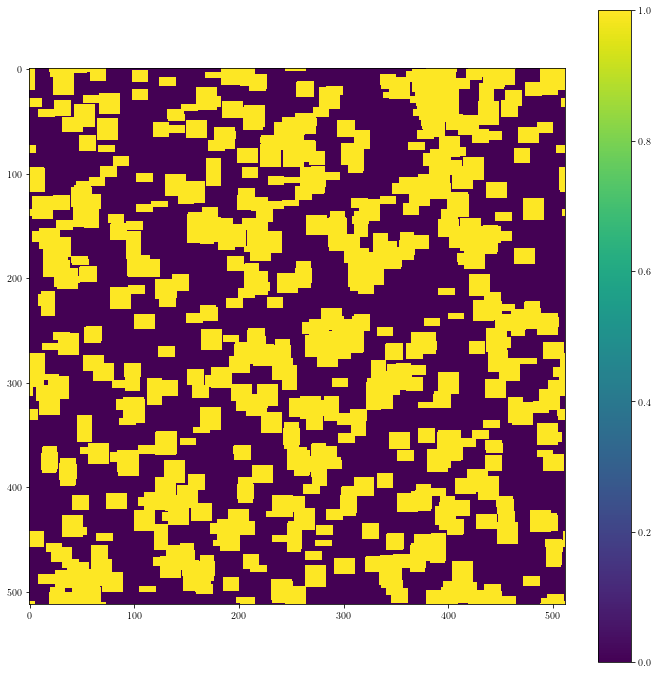

In [18]:
bool_mask = covering_mask_prime.copy()
bool_mask[bool_mask!=0]=1
# bool_mask = 
bool_mask = bool_mask.astype(int)
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(bool_mask)
_ = plt.colorbar()

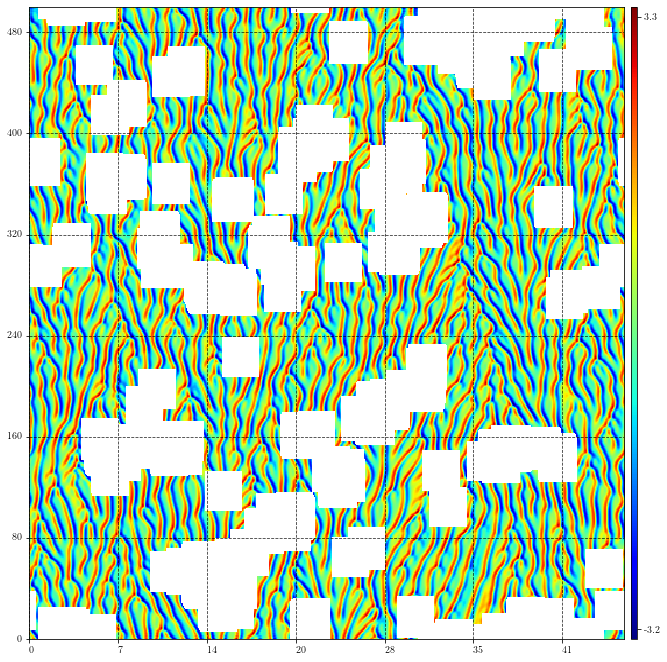

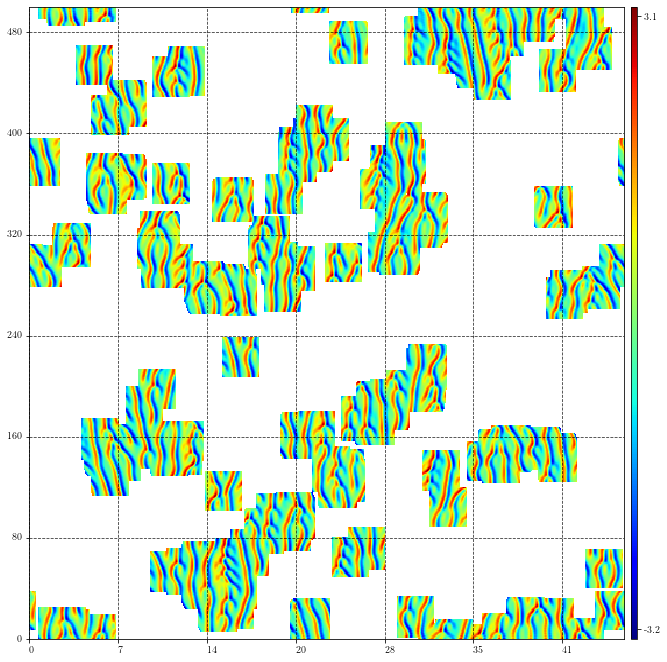

In [39]:
bool_mask = covering_mask_prime.copy()
bool_mask[bool_mask!=0]=1
base.__class__(state=np.ma.masked_array(base.state, mask=bool_mask, fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()
base.__class__(state=np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool)), fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()

The results are not good. They can be improved by using the relative periodic orbits' "fundamental domains" which is to say, NOT the comoving frame. For this reason, the group orbit of every RelativeOrbitKS in the covering returns orbits in the fundamental domain or 'physical' frame. Because we are being exhaustive and using all group orbit members, the strictest values are used as thresholds. For the sake of chopping the computation into pieces, we shall call the cover function once for each family; this will also allow us to see how intense the overlap is per family, i.e. if the group orbits can be down sampled.
This might run into overflow issues however, as we are using the first 500 or so primes.

In [38]:
# Can actually pass generator itself, if we knew a priori how big each group orbit it. 
covering_group_orbits = []
cvals = []
for i, window in enumerate(covering_processed):
    window_group_orbit = []
    window_cvals = []
    # Only trying to capture spatial drift velocity with fundamental domains. 
    if window.__class__ not in [AntisymmetricOrbitKS, EquilibriumOrbitKS]:
        for g_window in window.group_orbit(fundamental_domain=True):
            window_group_orbit.append(g_window)
            window_cvals.append(strict_fd_cval[i])
    else:
        for g_window in window.group_orbit():
            window_group_orbit.append(g_window)
            window_cvals.append(strict_critical_values[i])
    cvals.append(window_cvals)
    covering_group_orbits.append(window_group_orbit)

This searches over the group orbit members of each of the 8 original orbits, over a single base orbit. Statistics on
the proportional areas covered are the next part.

In [25]:
family_masks = read_h5('../small_cover_family_masks.h5')

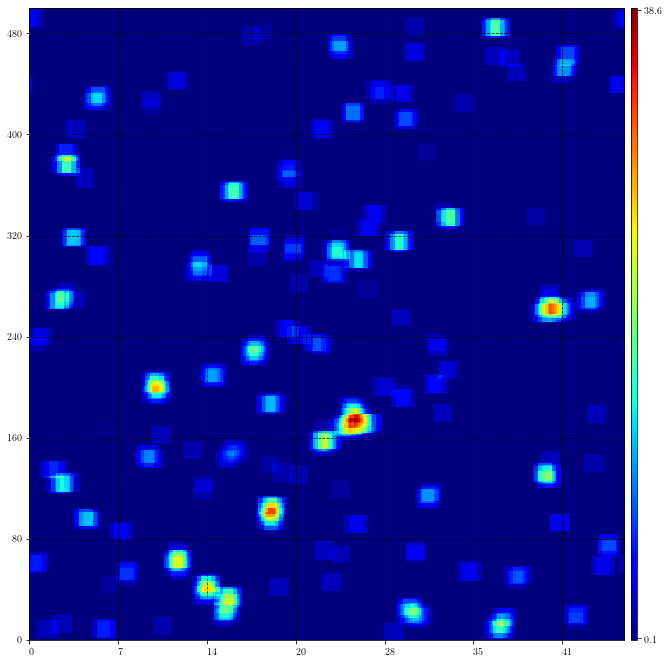

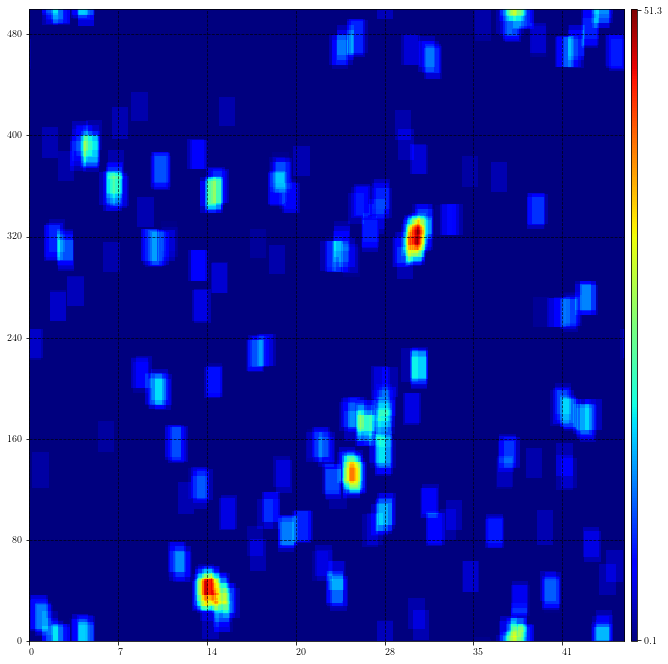

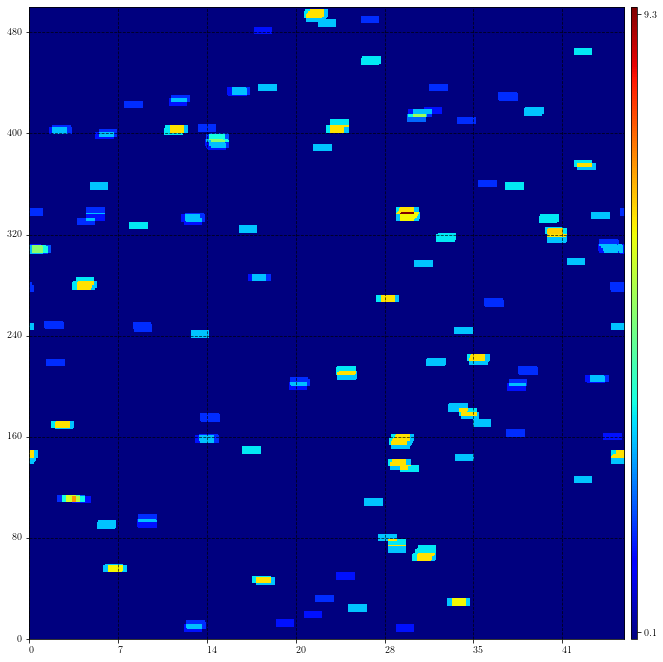

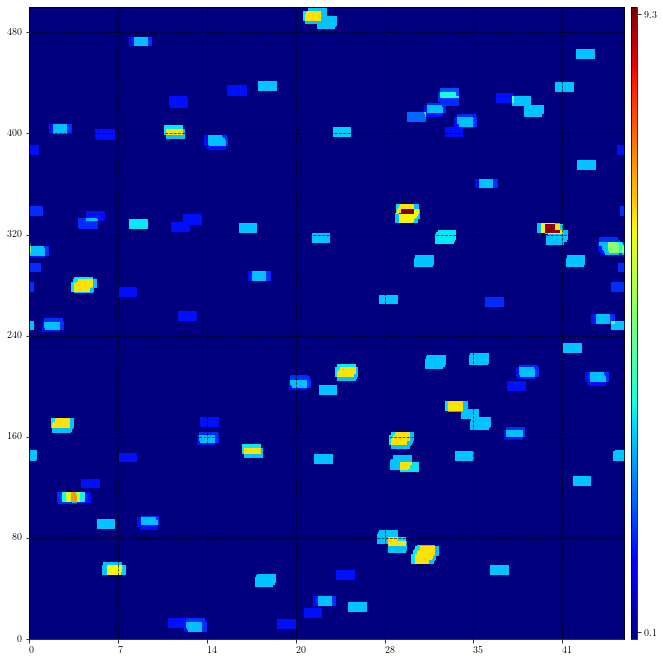

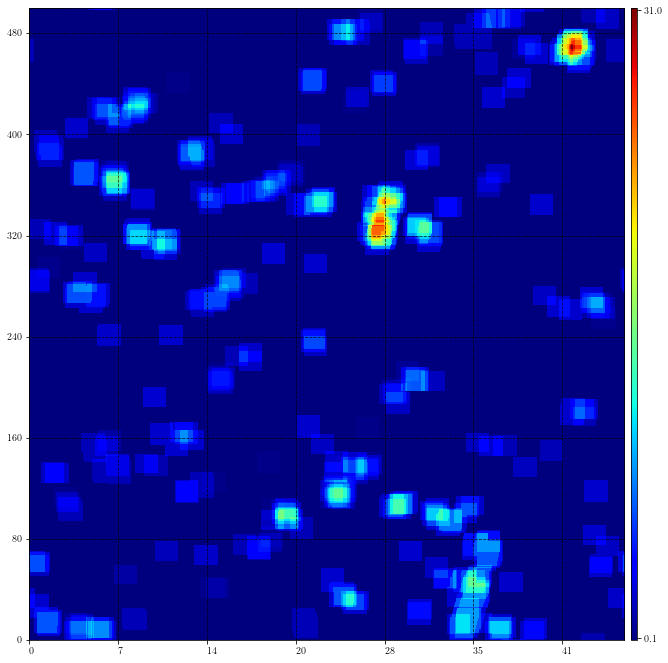

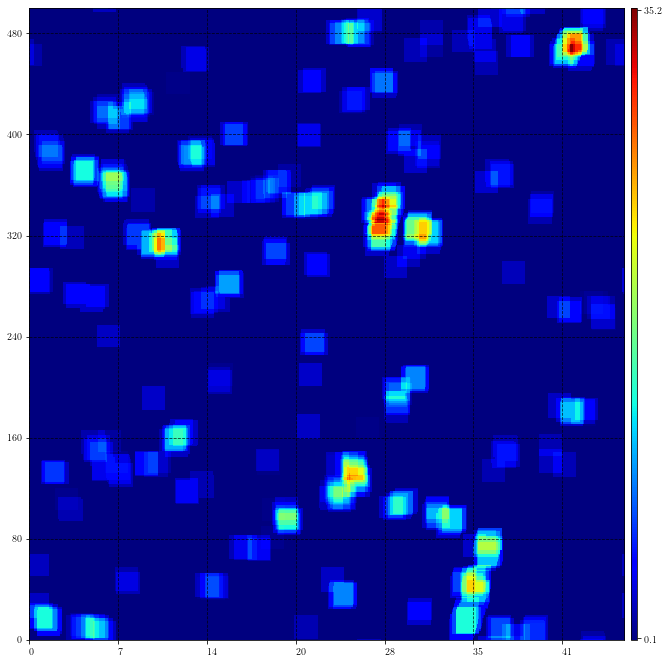

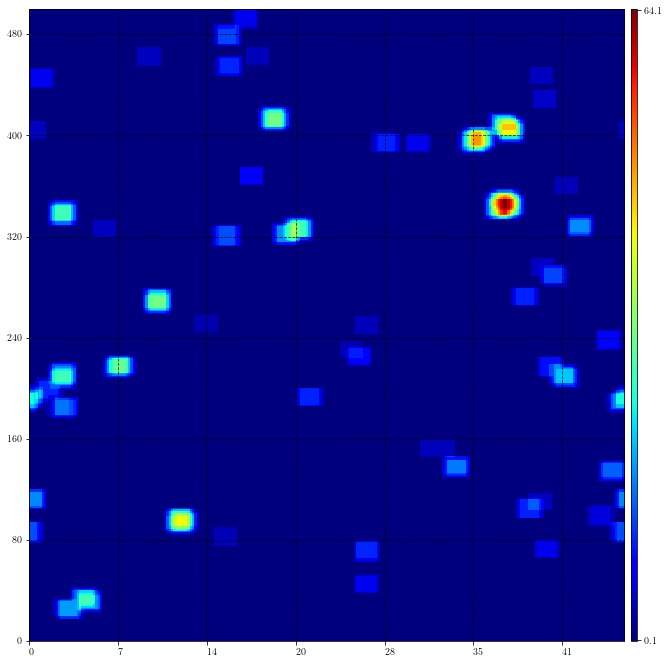

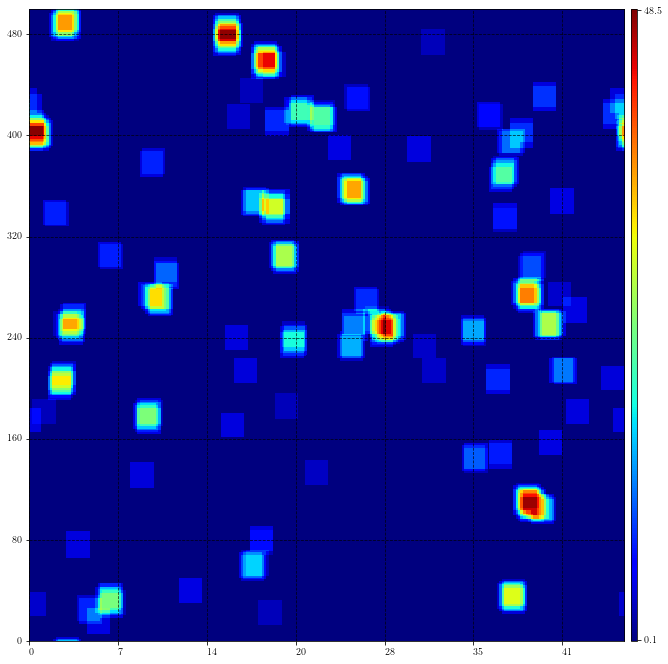

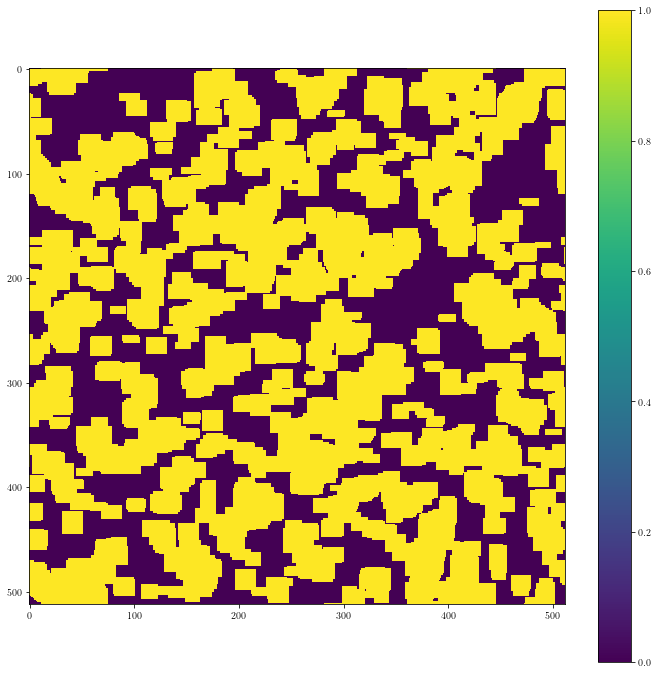

In [32]:
bool_mask = np.zeros([512, 512], dtype=bool)
for x in family_masks:
    x.plot()
    tmp = x.state.copy()
    tmp[tmp!=0]=1
    bool_mask = np.logical_or(bool_mask, tmp.astype(bool))
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(bool_mask.astype(int))
_ = plt.colorbar()

In [37]:
tmp = covering_mask_persistence_prime.copy()
tmp[tmp!=0]=1
tmp = tmp.astype(bool)
bool_mask = np.logical_or(bool_mask,tmp)

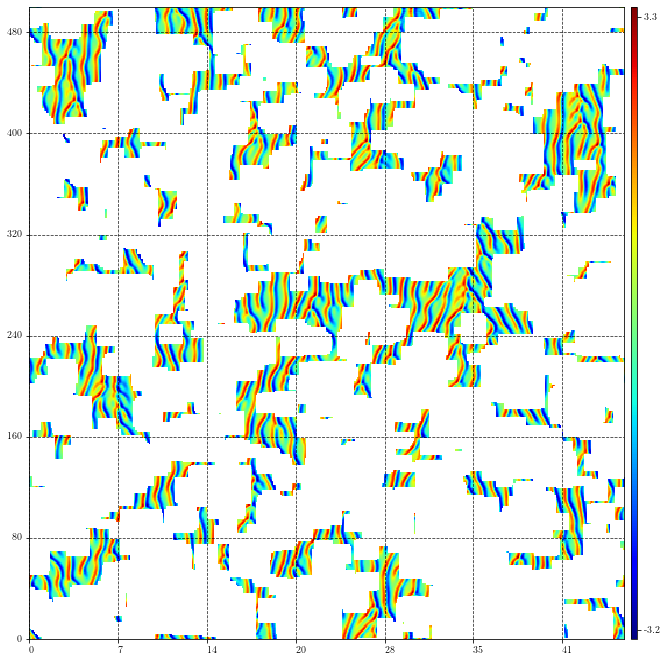

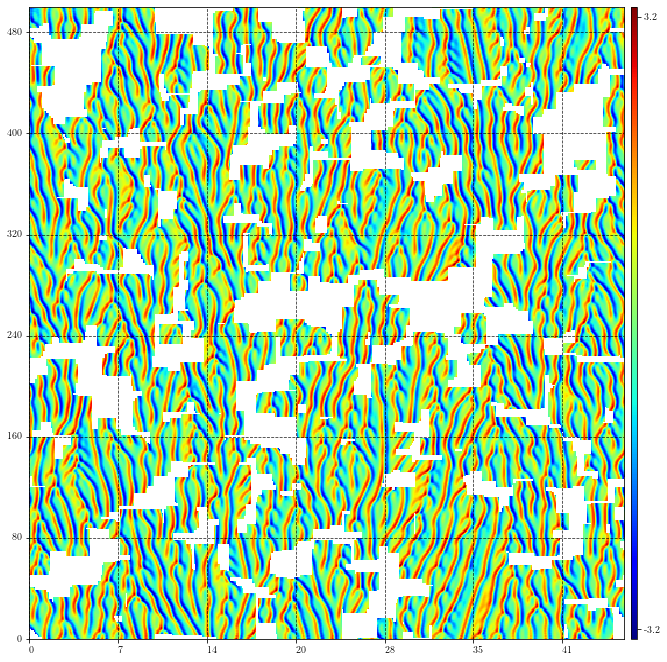

In [38]:
base.__class__(state=np.ma.masked_array(base.state, mask=bool_mask, fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()
base.__class__(state=np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool)), fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()

In [40]:
family_masks = []
times = []
times.append(time.time_ns()/10**9)
for cv, windows in zip(cvals, covering_group_orbits):
    family_masks.append(cover(base, cv, windows, mask_type='prime'))
    print('#', end='')
    times.append(time.time_ns()/10**9)

#

KeyboardInterrupt: 

Can leverage orbithunter class objects to save these masks in an h5 file.

In [82]:
# for fm in family_masks:
#     OrbitKS(state=fm, parameters=base.parameters, basis='field').to_h5(filename='small_cover_family_masks.h5')

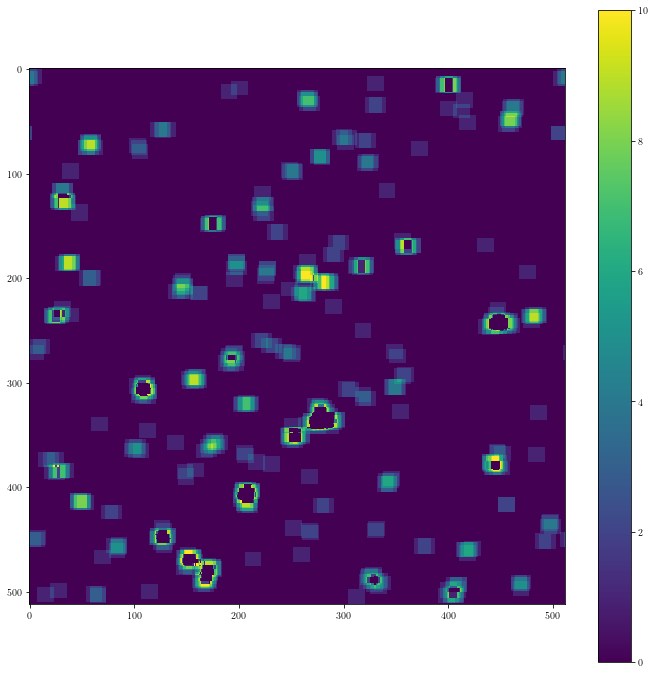

In [138]:
# for f in family_masks:
f = family_masks[0]
primes = first_nprimes(len(f))
factors = factor_prime_mask(f, primes)
count_encoding = np.zeros(family_masks[0].shape)
for fac in factors:
    fmp = fac.copy()
    fmp[fmp!=0]=1
    count_encoding += fmp
    
count_encoding[count_encoding>10]=0
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(count_encoding)
_ = plt.colorbar()

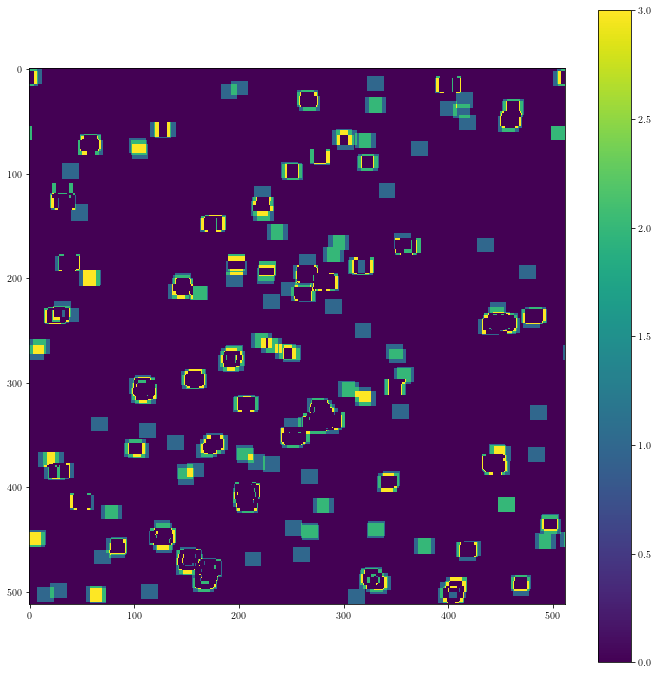

In [140]:
count_encoding[count_encoding>3]=0
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(count_encoding)
_ = plt.colorbar()

In [ ]:
primes = first_nprimes(len(family_masks))
new_primes_encoding = np.zeros(family_masks[0].shape)
for p, f in zip(primes, family_masks):
    # reencode to see overlap between families.
    fmp = f.copy()
    fmp[fmp!=0]=1
#     fmp[fmp==0]=0
    # simply want a count, do not need prime factoring
    new_primes_encoding += fmp

_ = plt.figure(figsize=(12,12))
_ = plt.imshow(new_primes_encoding)
_ = plt.colorbar()

In [100]:
for f in family_masks:
    primes = first_nprimes(len(f))
    new_primes_encoding = np.zeros(f[0].shape)
    factors = factor_prime_mask(mask, primes)
    prime_f = f.copy()
    boolfm[boolfm!=0]=1
    _ = plt.figure(figsize=(12,12))
    _ = plt.imshow(boolfm)
    _ = plt.colorbar()

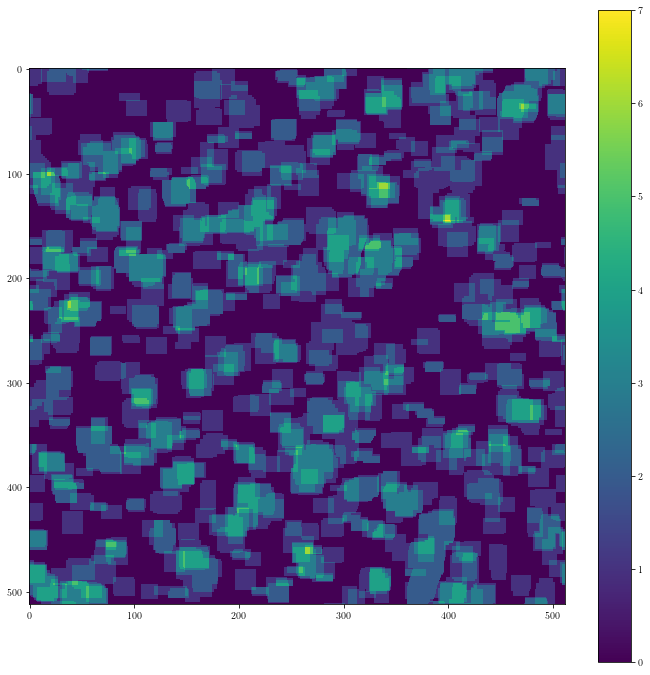

In [123]:
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(new_primes_encoding)
_ = plt.colorbar()

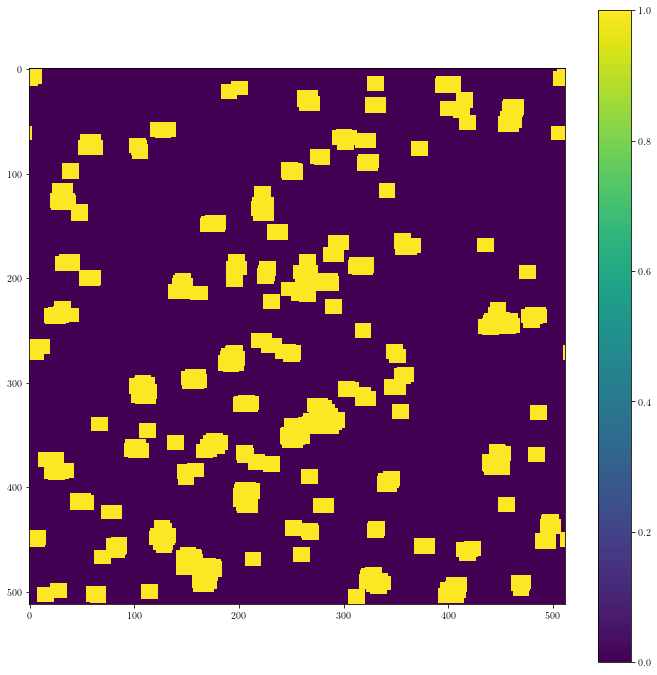

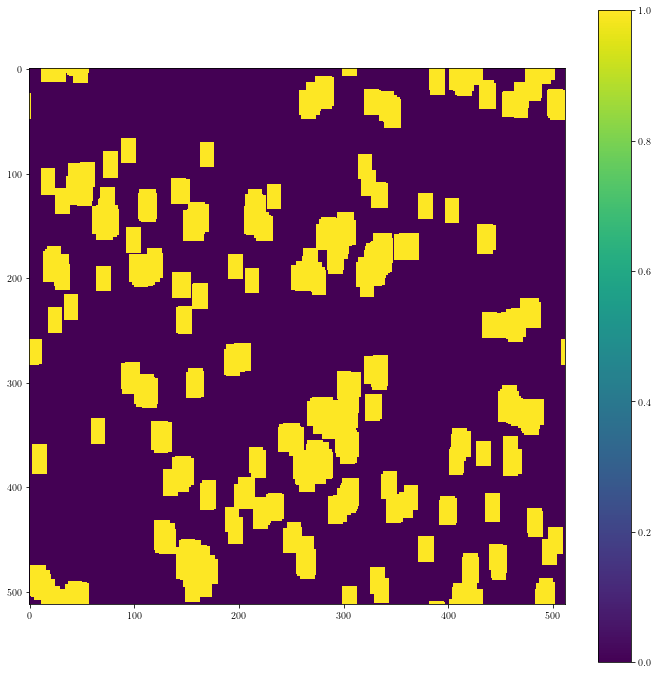

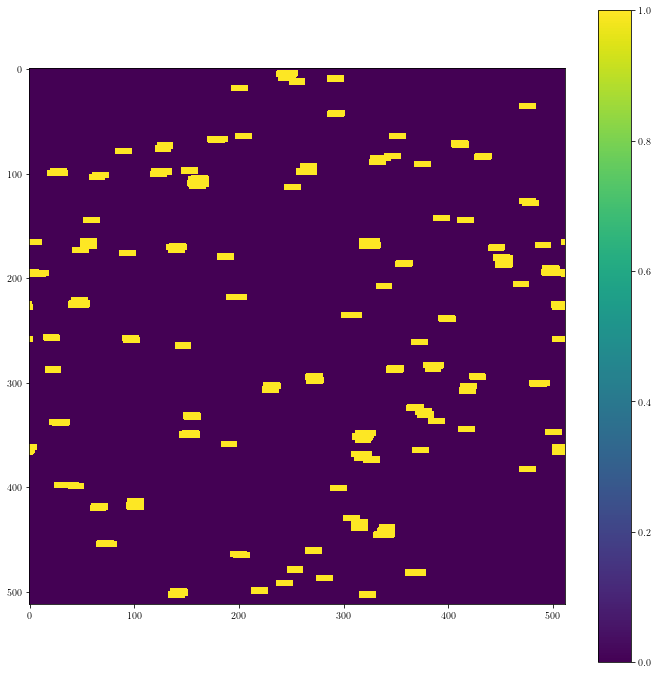

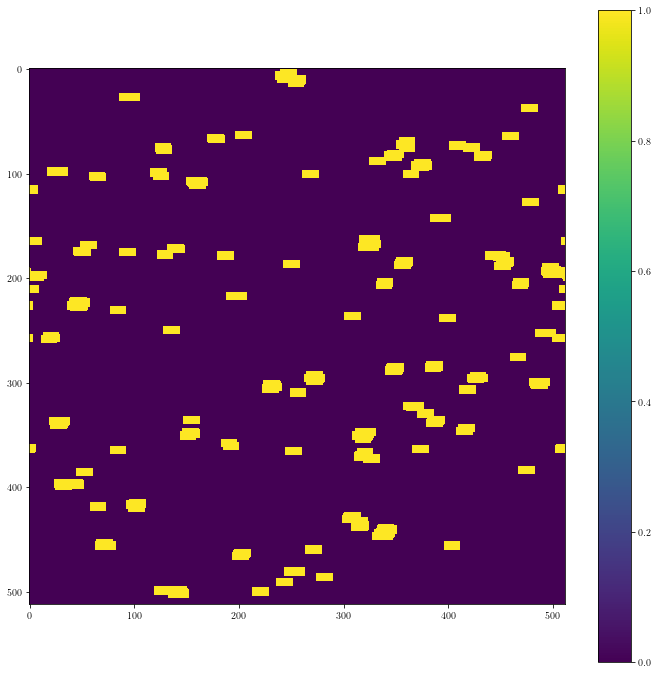

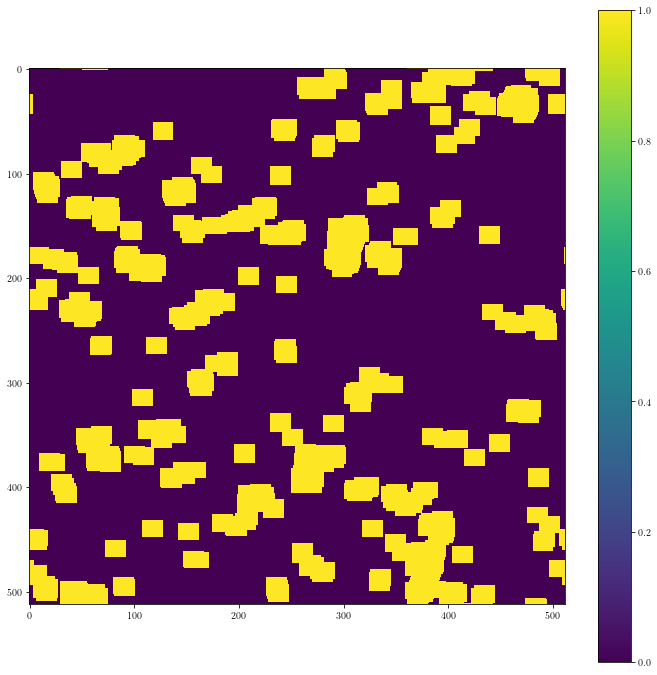

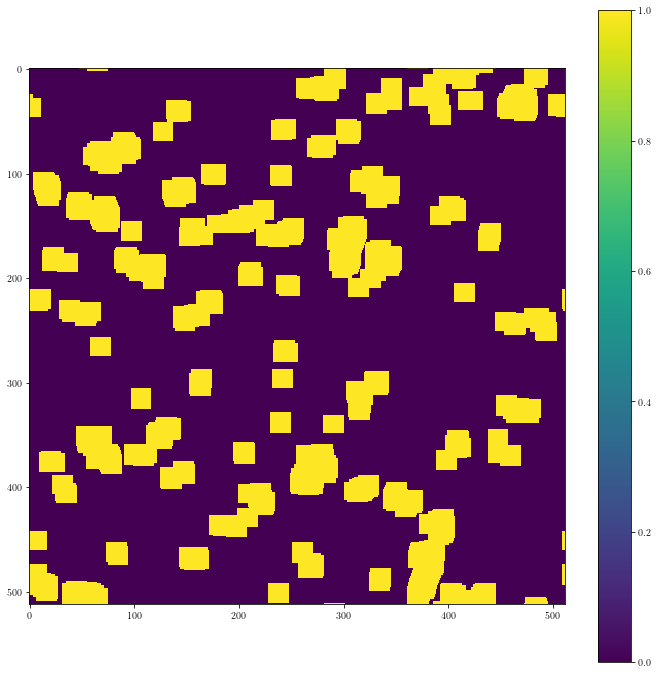

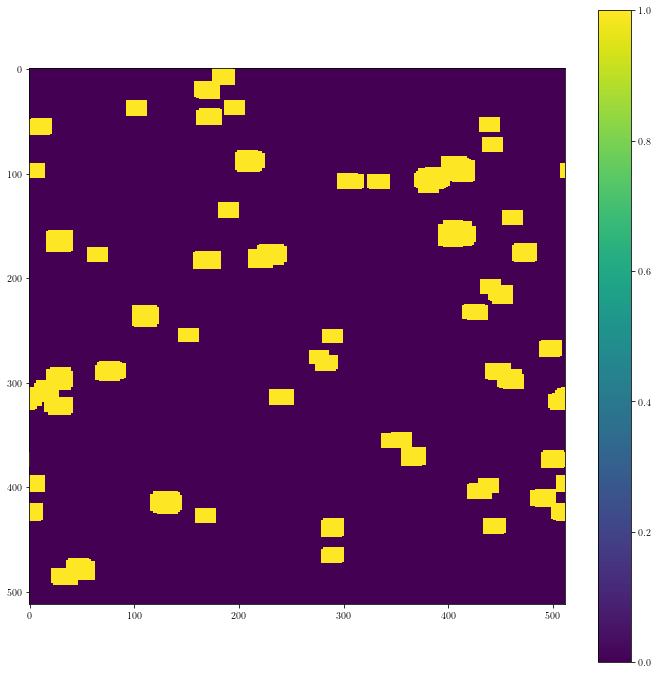

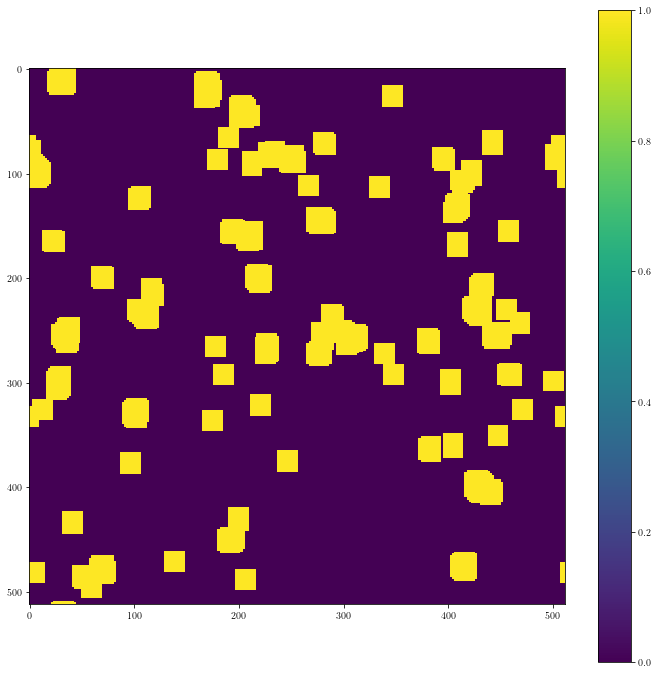

In [97]:
for f in family_masks:
    boolfm = f.copy()
    boolfm[boolfm!=0]=1
    _ = plt.figure(figsize=(12,12))
    _ = plt.imshow(boolfm)
    _ = plt.colorbar()

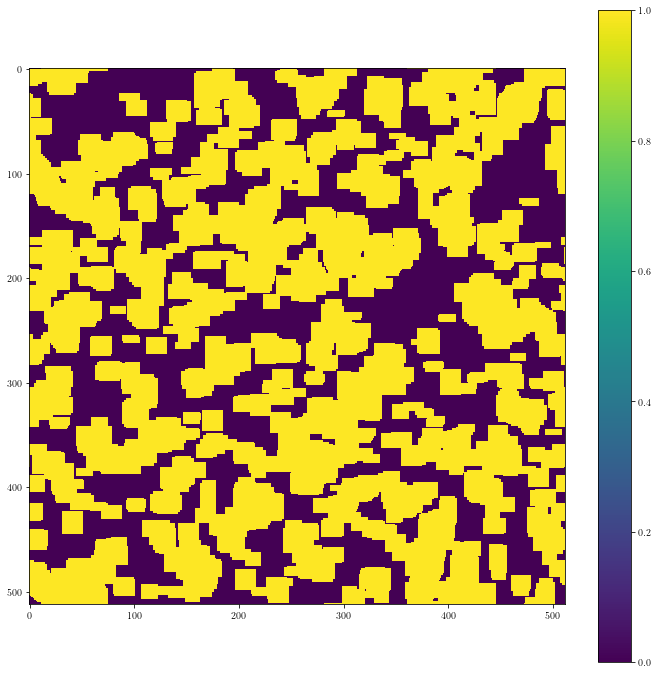

In [105]:
bool_union_mask = family_masks[0].copy().astype(bool)
primes = first_nprimes(len(family_masks))
for p, f in zip(primes, family_masks):
    boolfm = f.copy()
    boolfm[boolfm!=0]=1
    bool_union_mask = np.logical_or(bool_union_mask, boolfm.astype(bool))
    
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(bool_union_mask.astype(int))
_ = plt.colorbar()

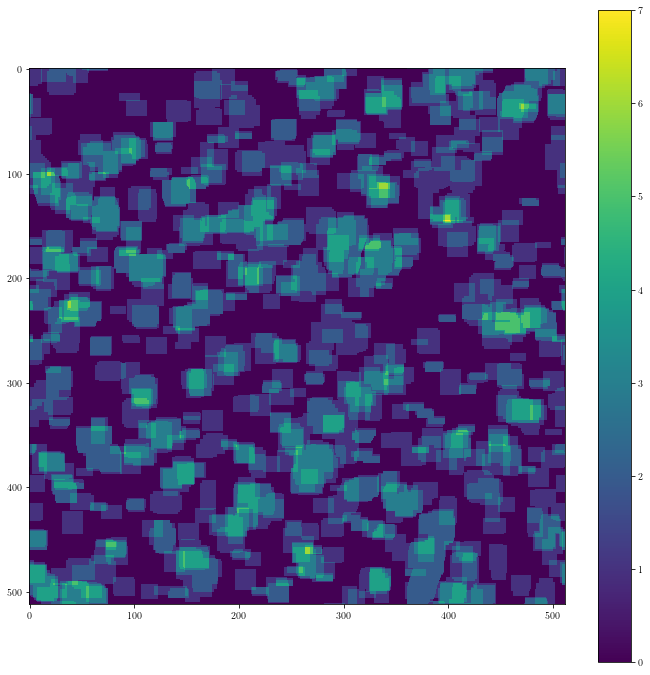

In [120]:
primes = first_nprimes(len(family_masks))
new_primes_encoding = np.zeros(family_masks[0].shape)
for p, f in zip(primes, family_masks):
    # reencode to see overlap between families.
    fmp = f.copy()
    fmp[fmp!=0]=1
    # fmp[fmp==0]=0
    # simply want a count, do not need prime factoring
    new_primes_encoding += fmp

_ = plt.figure(figsize=(12,12))
_ = plt.imshow(new_primes_encoding)
_ = plt.colorbar()

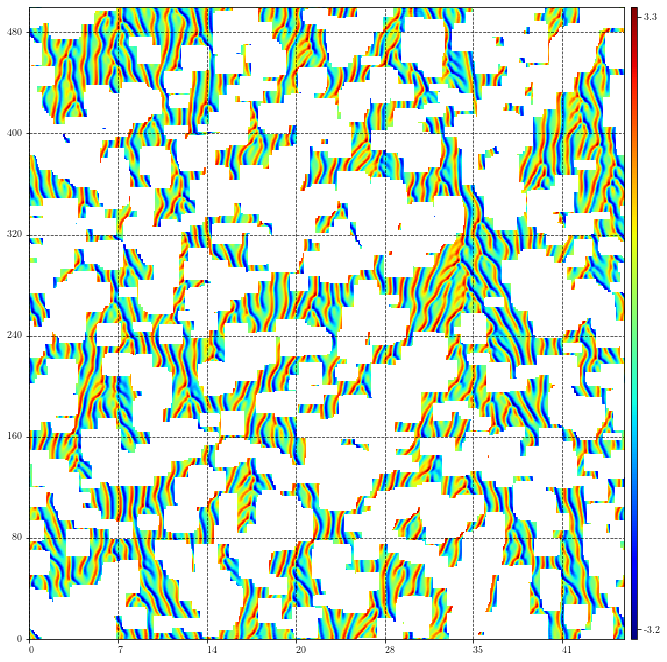

In [116]:
base.__class__(state=np.ma.masked_array(base.state, mask=bool_union_mask, fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()

In [52]:
family_masks = []
for cv, windows in zip(cvals, covering_group_orbits):
    family_masks.append(cover(base, cv, windows, mask_type='prime'))
    print('#', end='')

########

Can leverage orbithunter class objects to save these masks in an h5 file.

In [82]:
# for fm in family_masks:
#     OrbitKS(state=fm, parameters=base.parameters, basis='field').to_h5(filename='small_cover_family_masks.h5')

The previous run used the strict thresholds; before becoming less strict, let us simply be exhaustive with our covering. what if they are laxened?

In [ ]:
# Can actually pass generator itself, if we knew a priori how big each group orbit it. 
covering_group_orbits = []
cvals = []
for i, window in enumerate(covering_processed):
    window_group_orbit = []
    window_cvals = []
    # Only trying to capture spatial drift velocity with fundamental domains. 
    if window.__class__ not in [AntisymmetricOrbitKS, EquilibriumOrbitKS]:
        for g_window in window.group_orbit(rolls=(4, 4), fundamental_domain=True):
            window_group_orbit.append(g_window)
            window_cvals.append(fd_cval[i])
    else:
        for g_window in window.group_orbit(rolls=(4, 4)):
            window_group_orbit.append(g_window)
            window_cvals.append(critical_values[i])
    cvals.append(window_cvals)
    covering_group_orbits.append(window_group_orbit)

In [ ]:
lax_family_masks = []
for cv, windows in zip(cvals, covering_group_orbits):
    lax_family_masks.append(cover(base, cv, windows, mask_type='prime'))
    print('#', end='')

In [ ]:
# covering = [x.transform(to='field') for x in read_h5('small_cover.h5')]
# base = read_h5('../../notebooks/large_trajectories.h5', '/1')

# strict_critical_values = [17.749967821715273, 23.474046394615176, 8.347856140811789, 10.637196421774007, 21.47428043021303,
#                          22.794332555706887, 49.355340899693545, 54.39977394863649, 23.695919373228644, 30.19197496572182]

# strict_fd_cval = [16.16515739615338,23.40098181344061,7.144852496026526, 8.705223743263488,19.63318603225569,
#                   21.648417485849258,26.910607878923713, 26.148049427626642,11.398396992276126,15.249482036755104]

# # covering_processed = covering_processed[:-4] + covering_processed[-2:]
# covering_processed = np.array(covering_processed)[[0, 1, 2, 3, 4, 5, 8, 9]]
# # for i in range(6):
# #     covering_processed[i] = covering_processed[i].to_fundamental_domain()

# # strict_critical_values = strict_critical_values[:-4] + strict_critical_values[-2:]
# strict_critical_values = np.array(strict_critical_values)[[0, 1, 2, 3, 4, 5, 8, 9]]

# # Can actually pass generator itself, if we knew a priori how big each group orbit it. 
# covering_group_orbits = []
# cvals = []
# for i, window in enumerate(covering_processed):
#     window_group_orbit = []
#     window_cvals = []
#     # Only trying to capture spatial drift velocity with fundamental domains. 
#     if window.__class__ not in [AntisymmetricOrbitKS, EquilibriumOrbitKS]:
#         for g_window in window.group_orbit(fundamental_domain=True):
#             window_group_orbit.append(g_window)
#             window_cvals.append(strict_fd_cval[i])
#     else:
#         for g_window in window.group_orbit():
#             window_group_orbit.append(g_window)
#             window_cvals.append(strict_critical_values[i])
#     cvals.append(window_cvals)
#     covering_group_orbits.append(window_group_orbit)

# family_masks = []
# times = []
# times.append(time.time_ns()/10**9)
# for cv, windows in zip(cvals, covering_group_orbits):
#     cv = cv[:1]
#     windows = windows[:1]
#     family_masks.append(cover(base, cv, windows, mask_type='prime'))
#     print('#', end='')
#     times.append(time.time_ns()/10**9)